In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [73]:
filings_metadata = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\filings_metadata.csv')
filings_metadata['SIC'] = filings_metadata['SIC'].fillna(0).astype(int)

# Companies over time

In [74]:
filings_metadata['Period of Report'] = pd.to_datetime(filings_metadata['Period of Report'], format='%Y-%m-%d')
filings_metadata['Filing Date'] = pd.to_datetime(filings_metadata['Filing Date'], format='%Y-%m-%d')
filings_metadata['reporting_year'] = filings_metadata['Period of Report'].dt.year


In [91]:
filings_metadata.groupby('reporting_year')['CIK'].agg(['count', 'nunique']).reset_index().tail(7)

,reporting_year,count,nunique
19,2019,5577,5515
20,2020,7023,6949
21,2021,7757,7663
22,2022,7482,7346
23,2023,6937,6834
24,2024,6218,6123
25,2025,91,91


Only include the filings relevant to the years [2020,2024]

In [94]:
filings_metadata = filings_metadata[filings_metadata.reporting_year.isin(range(2020,2025))]

In [114]:
companies_per_year = filings_metadata.groupby('reporting_year')[['CIK']].nunique()
companies_per_year.columns = ['companies']

# 1 vs 1A items over time

In [115]:
ai_mentions = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\ai_mentions.csv')
ai_mentions = ai_mentions[ai_mentions.reporting_year.isin(range(2020,2025))]

In [125]:
companies_ai_mentioned_norm = ai_mentions.groupby('reporting_year')[['cik']].nunique().rename(columns={'cik': 'companies'})/ companies_per_year
companies_ai_mentioned_norm.columns = ['companies_per']

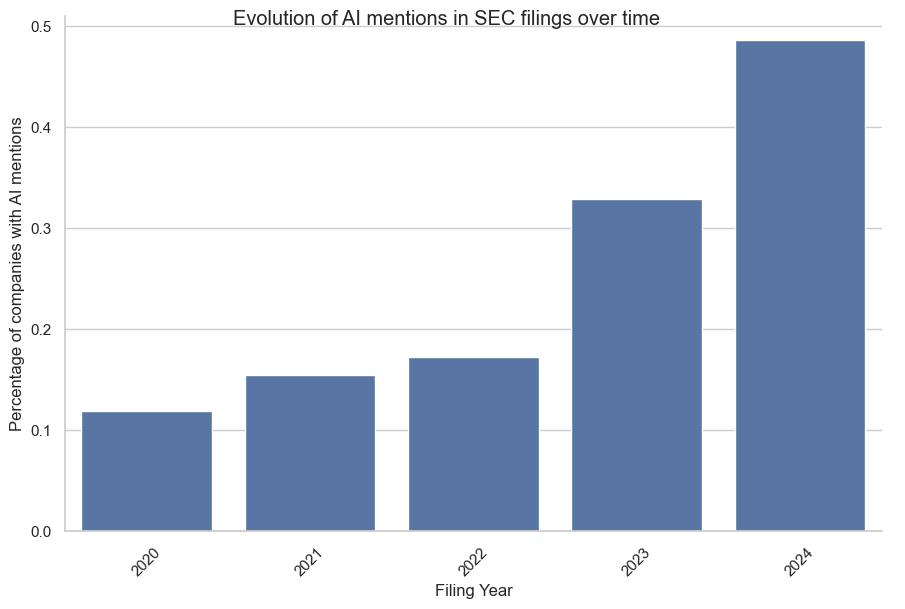

In [127]:
# Seaborn scatter plot of evolution in number of mentions over time (split by match field)
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style(style="whitegrid"):
    # Increase dot size
    g = sns.catplot(data=companies_ai_mentioned_norm.reset_index(), x='reporting_year', y='companies_per', kind='bar', height=6, legend_out=True, aspect=1.5)
    g.fig.suptitle('Evolution of AI mentions in SEC filings over time')

    g.set_xticklabels(rotation=45)
    g.set_xlabels('Filing Year')
    g.set_ylabels('Percentage of companies with AI mentions')



In [ ]:
grouped = ai_mentions[ai_mentions.match_field.isin(['1_matches', '1A_matches'])].groupby(['filing_year', 'match_field']).agg(['nunique'])[['cik']].reset_index()


In [81]:
filings_metadata['submission_length'] = (filings_metadata['Filing Date'] - filings_metadata['Period of Report']).dt.days

In [82]:
filings_metadata.submission_length.describe(percentiles=[0.9, 0.99])

count    41247.000000
mean        85.636871
std        200.182453
min          0.000000
50%         72.000000
90%         95.000000
99%        329.080000
max       8832.000000
Name: submission_length, dtype: float64

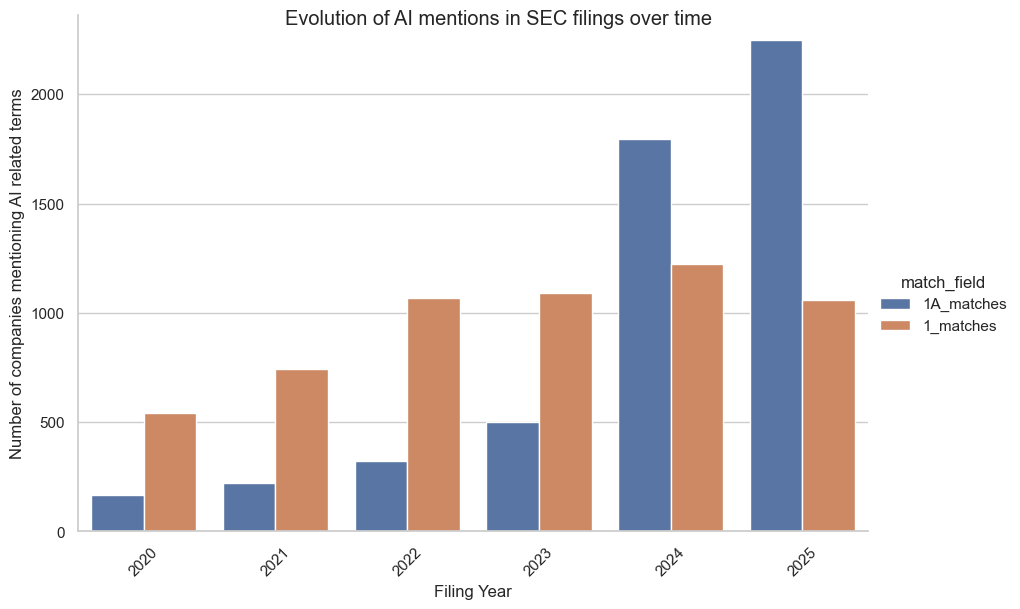

In [83]:
# Seaborn scatter plot of evolution in number of mentions over time (split by match field)
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style(style="whitegrid"):
    # Increase dot size
    g = sns.catplot(data=grouped, x='filing_year', y=('cik', 'nunique'), hue='match_field', kind='bar', height=6, legend_out=True, aspect=1.5)
    g.fig.suptitle('Evolution of AI mentions in SEC filings over time')

    g.set_xticklabels(rotation=45)
    g.set_xlabels('Filing Year')
    g.set_ylabels('Number of companies mentioning AI related terms')



In [ ]:
import seaborn as sns

# Industry level

In [ ]:
sic_codes = pd.read_csv(r'C:\Users\P70088982\Documents\edgar-crawler\datasets\sic_codes.csv').set_index('SIC Code')

In [ ]:
ai_mentions.cik = ai_mentions.cik.astype(int)

In [ ]:
df = ai_mentions.set_index('cik').join(filings_metadata.groupby(['CIK'])['SIC'].max(), how='left').reset_index().rename(columns={'index': 'cik'})
df = df.set_index('SIC').join(sic_codes, how='left').reset_index().rename(columns={'index': 'sic'})

In [ ]:
grouped = df[df.match_field.isin(['1_matches', '1A_matches'])].groupby(['filing_year', 'match_field', 'sic', 'Industry Title']).agg(['count', 'nunique'])[['cik']].reset_index()

In [ ]:
top_5 = grouped[grouped.sic.isin(grouped[grouped.filing_year==2025].sort_values(by=[('cik', 'nunique')], ascending=False).head(5).sic)]

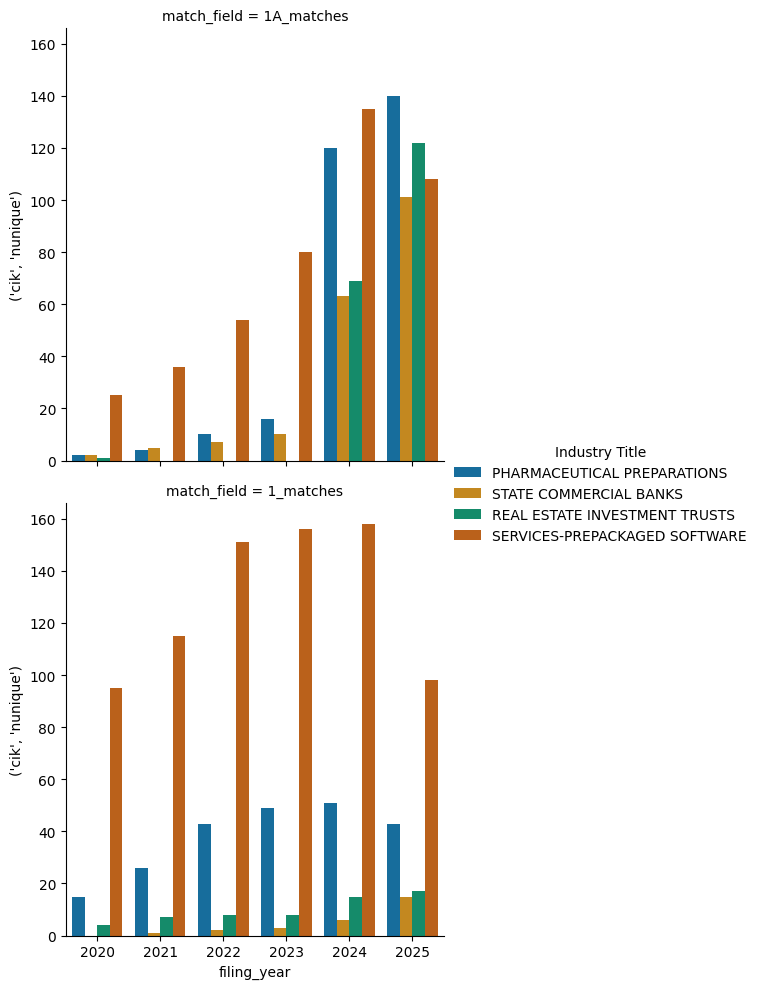

In [ ]:
sns.catplot(data=top_5, x='filing_year', y=('cik', 'nunique'), hue='Industry Title', row='match_field', kind='bar', palette='colorblind')